# Features
## Estimated Power
## Base map


In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from datetime import datetime

In [57]:
root = ET.parse('May_the_wind_be_ever_in_your_favor.gpx').getroot()

In [58]:
trk = root[1]
seg = trk[2]
point = seg[10]

frame = {}
frame['lat'] =  [float(x.get('lat')) for x in seg]
frame['lon'] =  [float(x.get('lon')) for x in seg]
frame['ele'] =  [float(x[0].text) for x in seg]
frame['time'] =  [datetime.strptime(x[1].text, '%Y-%m-%dT%H:%M:%SZ') for x in seg]

df = pd.DataFrame(frame)

In [59]:
df.head()

,lat,lon,ele,time
0,40.007087,-105.257127,1616.3,2019-09-09 18:19:32
1,40.007134,-105.257164,1616.5,2019-09-09 18:19:38
2,40.007153,-105.257215,1616.7,2019-09-09 18:19:40
3,40.007172,-105.257260,1616.8,2019-09-09 18:19:41
4,40.007162,-105.257336,1617.0,2019-09-09 18:19:43


In [60]:
def to_cartesian(Lat, Long,ele): # Uses kilometers
    Lat = np.deg2rad(Lat) # Convert degrees to radians for numpy trig
    Long = np.deg2rad(Long)
    
    earth_radius = 6371 # km
    radius = earth_radius + (ele/1000)
    x_pos = radius*np.cos(Lat)*np.sin(Long) # Convert spherical coordinates to cartesian
    y_pos = radius*np.cos(Lat)*np.cos(Long) # Assumes earths radius = 1
    z_pos = radius*np.sin(Lat)
    
    pos = pd.concat([x_pos,y_pos,z_pos],axis=1)
    return [np.array(x) for x in pos.values]

def distance(p1,p2):
    if p1 is None or p2 is None:
        return None
    return 1000*sum((p2-p1)**2)**.5 # Converts kilometers to meters

In [61]:
df['cart'] = to_cartesian(df.lat,df.lon, df.ele)

In [62]:
prev_point = None
dists = []
for point in df.cart:
    dists.append(distance(prev_point, point))
    prev_point = point
    
df['delta_dist'] = dists

In [63]:
df['delta_time'] = df.time.diff() / np.timedelta64(1, 's')

In [64]:
df['speed'] = df.delta_dist / df.delta_time

In [65]:
df['delta_ele'] = df.ele.diff()

In [66]:
df.dtypes

lat                  float64
lon                  float64
ele                  float64
time          datetime64[ns]
cart                  object
delta_dist           float64
delta_time           float64
speed                float64
delta_ele            float64
dtype: object

In [67]:
df.head()

,lat,lon,ele,time,cart,delta_dist,delta_time,speed,delta_ele
0,40.007087,-105.257127,1616.3,2019-09-09 18:19:32,"[-4709.160720306854, -1284.4939018138944, 4096...",NaN,NaN,NaN,NaN
1,40.007134,-105.257164,1616.5,2019-09-09 18:19:38,"[-4709.156796396759, -1284.4960988057585, 4096...",6.107587,6.0,1.017931,0.2
2,40.007153,-105.257215,1616.7,2019-09-09 18:19:40,"[-4709.154490153, -1284.4999733128654, 4096.84...",4.835641,2.0,2.417820,0.2
3,40.007172,-105.257260,1616.8,2019-09-09 18:19:41,"[-4709.152244521696, -1284.5033345188426, 4096...",4.378687,1.0,4.378687,0.1
4,40.007162,-105.257336,1617.0,2019-09-09 18:19:43,"[-4709.151378313914, -1284.5098094521065, 4096...",6.572543,2.0,3.286271,0.2


When calculating air resistance, [Cycling Power Labs](https://www.cyclingpowerlab.com/CyclingAerodynamics.aspx) suggests the CdA = 0.4. This accounts for air resistance and frontal area of the average rider on the hoods.

In [114]:
m = 76
g = 9.8
ele_min = df.ele.min()

df['energy'] = m*g*(df.ele-ele_min)+.5*m*df.speed**2
drag_constant = 0.32
air_resistance = drag_constant * df.speed**3
df['power'] = (df.energy.diff()/df.delta_time) + air_resistance

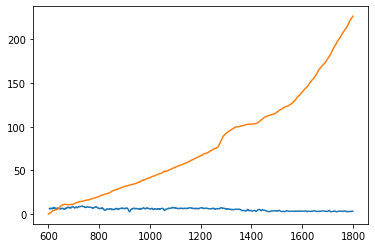

In [115]:
start = 600
frame = 1200
plt.plot(df.speed[start:start+frame].rolling(5).mean())
plt.plot(df.ele[start:start+frame] - df.ele[start])

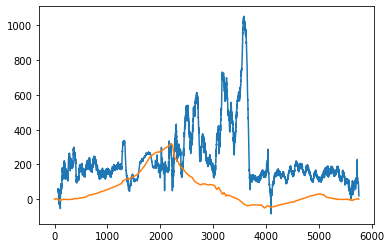

In [116]:
avg_power = df.power.rolling(60).mean()
plt.plot(avg_power)
plt.plot(df.ele-df.ele[0])

In [117]:
avg_power[avg_power > 0].mean()

226.73103375442682

In [118]:
hill_power = df.power[df.delta_ele > 0]
hill_power.mean()

216.4248634700847

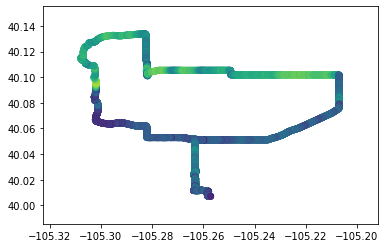

In [73]:
plt.scatter(df.lon,df.lat, c=df.speed)
plt.show()

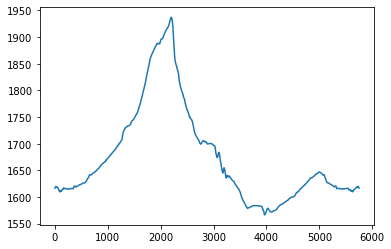

In [74]:
plt.plot(df.ele)